#### The goal of this project is to beat the result of this paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf which is 50.76% accuracy on the food101 dataset####

In [4]:
import tensorflow as tf

## Load the food101 dataset using TensorFlow Datasets ##

In [19]:
import tensorflow_datasets as tfds

(train_data, test_data), ds_info = tfds.load(name = 'food101',
                                             split = ['train', 'validation'],
                                             as_supervised = True,
                                             with_info = True,
                                             shuffle_files = True)

## Explore the dataset ##

In [20]:
# Get class labels
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [21]:
# Basic info about images
for image, label in train_data.take(1):
  print(f'Image shape: {image.shape}')
  print(f'Image datatype: {image.dtype}')
  print(f'Image label: {label}')
  print(f'Image class: {class_names[label]}')


Image shape: (512, 384, 3)
Image datatype: <dtype: 'uint8'>
Image label: 19
Image class: chicken_quesadilla


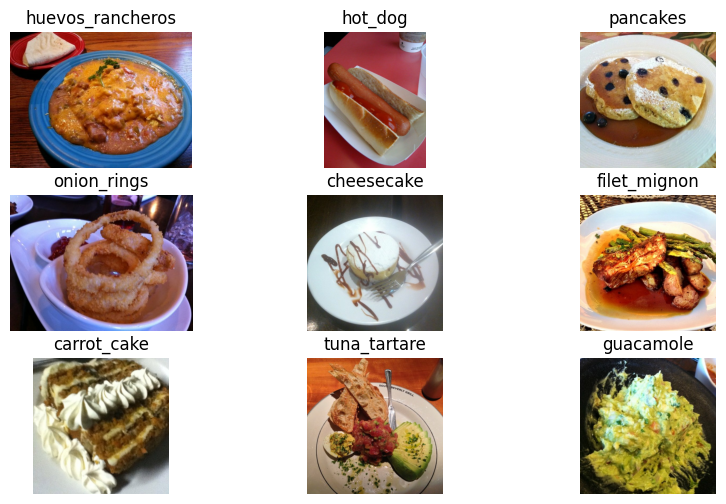

In [22]:
# Plot a couple of images
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 3, ncols = 3)
fig.set_size_inches(10,6)
i, j = 0, 0
for image, label in train_data.take(9):
  if j < 3:
    ax[i][j].imshow(image)
    ax[i][j].set(title = f"{class_names[label]}")
    ax[i][j].set_axis_off()
    j+=1
  else:
    i += 1
    j = 0
    ax[i][j].imshow(image)
    ax[i][j].set(title = f"{class_names[label]}")
    ax[i][j].set_axis_off()
    j+= 1

plt.show()

## Preprocessing the data ##

In [23]:
# Dtype of images is uint8, better to cast into float32
def cast_to_float32_and_resize(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, size = (224, 224))
  return tf.cast(image, tf.float32), label

# Cast and turn train and test dataset into batches
train_data = train_data.map(map_func = cast_to_float32_and_resize, num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.map(map_func = cast_to_float32_and_resize, num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Create modeling callbacks ##

In [25]:
import datetime

checkpoint_path = "food_vision_checkpoint/cp.chpk"

# Chechpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                monitor = 'val_loss',
                                                save_best_only = True,
                                                save_weights_only = True,
                                                )

tensorboard = tf.keras.callbacks.TensorBoard(log_dir = "food_vision_tenorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

## Setup mixed precision training ##

In [26]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build preprocessing layer ##

In [27]:
# Simple layer to resize all images to (224, 224, 3). No scaling is needed for EfficientNet

preprocessing_layer = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(height = 224, width = 224)
])

## Build feature extraction model ##

In [28]:
base_model = tf.keras.applications.EfficientNetB7(include_top = False)
base_model.trainable = False

# input layer
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input_layer')

# passing data through base model
x = base_model(inputs, training = False)

# extracting feature vector
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# passing data through output layer
x = tf.keras.layers.Dense(101)(x)

# need to set-up final softmax activation manually due to mixed precision
outputs = tf.keras.layers.Activation('softmax', dtype = tf.float32, name = 'output_layer')(x)

model = tf.keras.Model(inputs, outputs)

# compiling the model, use sparse categorical cross-entropy because labels are not hot-encoded
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)


## Check if mixed precision is used

In [29]:
for layer in model.layers:
  print(f'Layer name:{layer.name}, layer trainable: {layer.trainable}, layer dtype: {layer.dtype},, layer policy: {layer.dtype_policy}')

Layer name:input_layer, layer trainable: True, layer dtype: float32,, layer policy: <Policy "float32">
Layer name:efficientnetb7, layer trainable: False, layer dtype: float32,, layer policy: <Policy "mixed_float16">
Layer name:global_average_pooling2d_2, layer trainable: True, layer dtype: float32,, layer policy: <Policy "mixed_float16">
Layer name:dense_1, layer trainable: True, layer dtype: float32,, layer policy: <Policy "mixed_float16">
Layer name:output_layer, layer trainable: True, layer dtype: float32,, layer policy: <Policy "float32">


## Training the model ##

In [30]:
history_feature_extraction = model.fit(train_data,
          epochs = 3,
          validation_data = test_data,
          steps_per_epoch = len(train_data),
          validation_steps = len(test_data),
          callbacks = [checkpoint, tensorboard])

Epoch 1/3
2368/2368 [==============================] - 642s 258ms/step - loss: 1.7951 - accuracy: 0.5518 - val_loss: 1.2675 - val_accuracy: 0.6631
Epoch 2/3
 486/2368 [=====>........................] - ETA: 6:01 - loss: 1.3636 - accuracy: 0.6474

KeyboardInterrupt: ignored